In [52]:
import numpy as np

import matplotlib.pyplot as plt

from netCDF4 import Dataset

from FiniteDiff import FiniteDiff

## Load the Original / Unfiltered Data

In [53]:
with Dataset( 'velocity_sample.nc', 'r' ) as dset:
    
    lon = dset['longitude'][:]
    lat = dset['latitude'][:]
    
    uo = dset['uo'][0,0,:,:]
    vo = dset['vo'][0,0,:,:]
    
    Phi = dset['phi'][0,0,:,:]
    Psi = dset['psi'][0,0,:,:]

## Plot Original / Unfiltered Fields

Text(0.0, 1.0, 'D) Streamfunction')

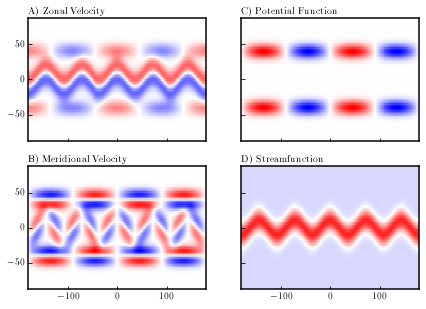

In [54]:
fig, axes = plt.subplots( 2, 2, sharex = True, sharey = True, figsize = (7,5) )

axes[0,0].pcolormesh( lon, lat, uo,  vmin = -0.1, vmax = 0.1 )
axes[1,0].pcolormesh( lon, lat, vo,  vmin = -0.1, vmax = 0.1 )

cv = np.max(np.abs(Phi))
axes[0,1].pcolormesh( lon, lat, Phi, vmin = -cv, vmax = cv )
axes[1,1].pcolormesh( lon, lat, Psi, vmin = -cv, vmax = cv )

axes[0,0].set_title( "A) Zonal Velocity",      loc = 'left', pad = 3 )
axes[1,0].set_title( "B) Meridional Velocity", loc = 'left', pad = 3 )
axes[0,1].set_title( "C) Potential Function",  loc = 'left', pad = 3 )
axes[1,1].set_title( "D) Streamfunction",      loc = 'left', pad = 3 )

### Load the Helmholtz Projection

In [55]:
with Dataset( 'projection_ui.nc', 'r' ) as dset:
    
    Phi_proj = dset['Phi'][0,0,:,:]
    Psi_proj = dset['Psi'][0,0,:,:]

## Plot the Helmholtz Projection with Errors

Text(0.0, 1.0, 'F) $\\Psi$ Projection Error')

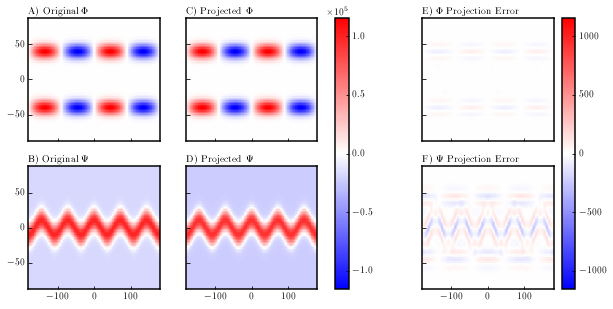

In [63]:
fig, axes = plt.subplots( 2, 3, sharex = True, sharey = True, figsize = (10,5) )

cv = np.max(np.abs(Phi))

qm = axes[0,0].pcolormesh( lon, lat, Phi, vmin = -cv, vmax = cv )
axes[1,0].pcolormesh(      lon, lat, Psi, vmin = -cv, vmax = cv )

axes[0,1].pcolormesh( lon, lat, Phi_proj, vmin = -cv, vmax = cv )
axes[1,1].pcolormesh( lon, lat, Psi_proj, vmin = -cv, vmax = cv )

qm2 = axes[0,2].pcolormesh( lon, lat,  Phi                 -  Phi_proj,                      vmin = -cv / 1e2, vmax = cv / 1e2 )
axes[1,2].pcolormesh(       lon, lat, (Psi - np.mean(Psi)) - (Psi_proj - np.mean(Psi_proj)), vmin = -cv / 1e3, vmax = cv / 1e3 )

plt.colorbar( qm,  ax = axes[:,:2] )
plt.colorbar( qm2, ax = axes[:,2] )

axes[0,0].set_title( "A) Original $\Phi$", loc = 'left', pad = 3 )
axes[1,0].set_title( "B) Original $\Psi$", loc = 'left', pad = 3 )

axes[0,1].set_title( "C) Projected $\Phi$", loc = 'left', pad = 3 )
axes[1,1].set_title( "D) Projected $\Psi$", loc = 'left', pad = 3 )

axes[0,2].set_title( "E) $\Phi$ Projection Error", loc = 'left', pad = 3 )
axes[1,2].set_title( "F) $\Psi$ Projection Error", loc = 'left', pad = 3 )

## Load the Coarse-Graining Results

In [57]:
full_data = { 'filename' : 'RESULTS_full.nc',      'label' : 'Full Vel.' }
tor_data  = { 'filename' : 'RESULTS_toroidal.nc',  'label' : 'Tor. Vel.' }
pot_data  = { 'filename' : 'RESULTS_potential.nc', 'label' : 'Pot. Vel.' }

for dataset in [full_data, tor_data, pot_data]:
    with Dataset( dataset['filename'], 'r' ) as dset:
        
        dataset['ell'] = dset['ell'][:]
        dataset['lat'] = dset['latitude'][:]
        
        dataset['regions'] = [ reg.strip() for reg in dset['region'] ]
        
        dataset['cKE'] = np.squeeze(dset['coarse_KE_area_average'][Ellipsis])
        dataset['cEN'] = np.squeeze(dset['enstrophy_area_average'][Ellipsis])

### Create finite difference derivatives to get spectra

In [58]:
ddk    = FiniteDiff(          1. / dataset['ell'],  4, Sparse = True, Uniform = False, Periodic = False )
ddlogk = FiniteDiff( np.log10(1. / dataset['ell']), 4, Sparse = True, Uniform = False, Periodic = False )

## Create and Plot Filtering Spectra

The following code block plots the globally-averaged filtering spectra of kinetic energy and enstrophy.

Feature to note:
1. Enstrophy is toroidal-only, as expected
2. Filtering spectra show potential peak at slightly smaller scales than toroidal, matching the smaller meridional scale of the potential function (see oscript that creates initial velocity fields)
3. In all spectra, there is a 'divot' near 600km. This is a resolution artefact resulting from the spacing between filter scales being smaller than the grid-scale. This 'divot' is an indicator of what scales should be considered too small to have reliable results.

Text(0.0, 1.0, 'F) Enstrophy Spectrum : $k$-Weighted')

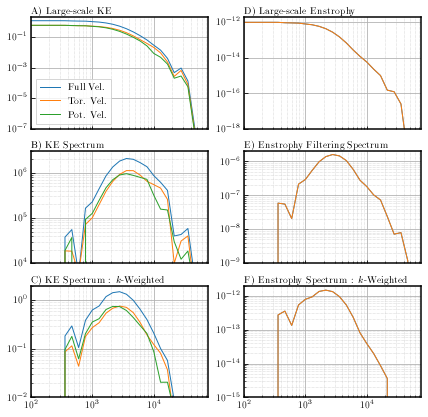

In [59]:
region = 'Global'

fig, axes = plt.subplots( 3, 2, sharex = True, sharey = False, figsize = (7,7) )

for dataset in [full_data, tor_data, pot_data]:
    
    region_index = dataset['regions'].index(region)
    
    axes[0,0].plot( dataset['ell'] / 1e3,             dataset['cKE'][:,region_index],   label = dataset['label'] )
    axes[1,0].plot( dataset['ell'] / 1e3, ddk.dot(    dataset['cKE'][:,region_index] ), label = dataset['label'] )
    axes[2,0].plot( dataset['ell'] / 1e3, ddlogk.dot( dataset['cKE'][:,region_index] ), label = dataset['label'] )
    
    axes[0,1].plot( dataset['ell'] / 1e3,             dataset['cEN'][:,region_index],   label = dataset['label'] )
    axes[1,1].plot( dataset['ell'] / 1e3, ddk.dot(    dataset['cEN'][:,region_index] ), label = dataset['label'] )
    axes[2,1].plot( dataset['ell'] / 1e3, ddlogk.dot( dataset['cEN'][:,region_index] ), label = dataset['label'] )
    
    
for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid( which = 'major' )
    ax.grid( which = 'minor', linestyle = ':', linewidth = 0.5 )
    
    ax.set_xlim( dataset['ell'].min() / 1e3, dataset['ell'].max() / 1e3 )

axes[0,0].set_ylim( 1e-7, 2 )
axes[1,0].set_ylim( 1e4,  3e6 )
axes[2,0].set_ylim( 1e-2, 2e0 )

axes[0,1].set_ylim( 1e-18, 2e-12 )
axes[1,1].set_ylim( 1e-9,  2e-6 )
axes[2,1].set_ylim( 1e-15, 2e-12 )
    
axes[0,0].legend()

axes[0,0].set_title('A) Large-scale KE', loc = 'left', pad = 3)
axes[1,0].set_title('B) KE Spectrum', loc = 'left', pad = 3)
axes[2,0].set_title('C) KE Spectrum : $k$-Weighted', loc = 'left', pad = 3)

axes[0,1].set_title('D) Large-scale Enstrophy', loc = 'left', pad = 3)
axes[1,1].set_title('E) Enstrophy Filtering Spectrum', loc = 'left', pad = 3)
axes[2,1].set_title('F) Enstrophy Spectrum : $k$-Weighted', loc = 'left', pad = 3)